In [1]:
# Start from importing necessary packages.
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.cluster import DBSCAN

# make matplotlib plot inline (Only in Ipython).
warnings.filterwarnings('ignore')
%matplotlib inline

## DBSCAN: Density-Based Spatial Clustering of Applications with Noise

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

DBSCAN captures the insight that clusters are dense groups of points. The idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

### Parameters
- $Eps$: Maximum radius of the neighborhood.
- $MinPts$: Minimum number of points in the Eps-neighborhood of a point.

### Terms
- The Eps-neighborhood of a point $q$－$N_{Eps}$: A point $p \in N_{Eps}(q)$ if $D(p,q) \leq Eps$. (Point inside the circle).
- Outlier: Not in a cluster.
- Core point: $\left\vert N_{Eps}(q) \right\vert \geq MinPts$ (dense neighborhood).
- Border point: In cluster but neighborhood is not dense.

<div style="text-align:center"><img width="300px" src="./img/core-border-point.png"/></div>


- Directly density-reachable: A point $p$ is **directly density-reachable** from a point $q$ w.r.t $Eps$ and $MinPts$ if:
    - $p \in N_{Eps}(q)$, and $q$ is a **core point**.
    - $p$ **doesn't** need to be a core point.

<div style="text-align:center"><img width="250px" src="./img/directly-density-reachable.png"/></div>

- Density-reachable: A point $p$ is **density-reachable** from a point $q$ w.r.t. $Eps$ and $MinPts$ if there is a chain of points $p_1, \dots, p_n,\ p_1 = q,\ p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$.

<div style="text-align:center"><img width="150px" src="./img/density-reachable.png"/></div>

### The Algorithm
1. Randomly choose a point $p$.
2. Retrieve all points density-reachable from $p$ w.r.t. $Eps$ and $MinPts$.
3. If $p$ is a core point, a cluster is formed.
4. If $p$ is a border point, no points are density-reachable from $p$, then visit the next point.
5. Repeat the process until all the data points have been processed.

Let's begin to perform *DBSCAN* on spherical data

Number of clusters: 3
Homogeneity: 0.9820397966048764
Completeness: 0.9378109619395728


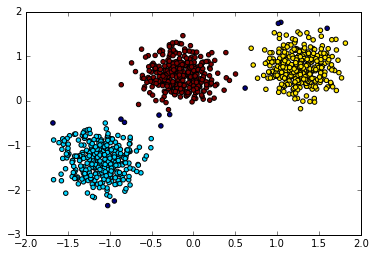

In [2]:
# Generate data with 3 centers.
X, y = make_blobs(n_samples=1000, 
                  n_features=2, 
                  centers=3,
                  random_state=170)

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(X)

# Plot the predictions
plt.scatter(X[:,0], X[:,1], c=y_pred)

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))

The **black** data points denote the **outliers** in the above result.

Note that we don't need to specify the number of clusters with *DBSCAN* algorithm.

Now, let's try *DBSCAN* on non-spherical data.

Number of clusters: 2
Homogeneity: 1.0
Completeness: 0.9815361467095759


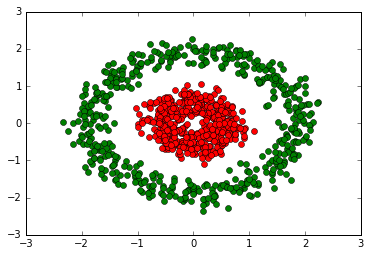

In [3]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))

Comparing to *K-means*, we can directly apply *DBSCAN* on this form of data distribution due to the density-based clustering criterion.

Note: It's worth mention that the *Silhouette score* is generally higher for **convex** clusters than other concepts of clusters, such as density based clusters.

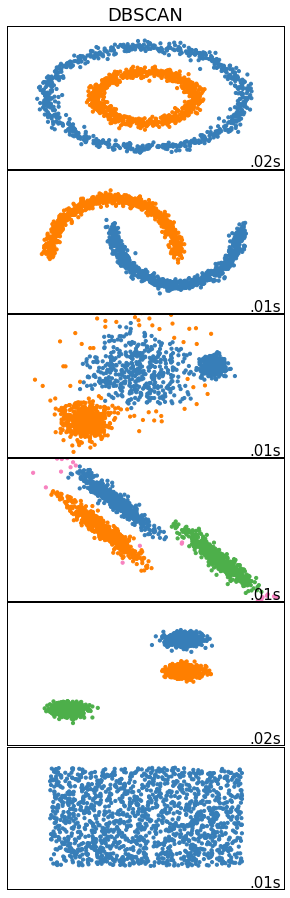

In [4]:
# print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(4, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (('DBSCAN', dbscan),)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

https://github.com/howardyclo/kmeans-dbscan-tutorial